# CSE488 
## Spark Tutorial in pySpark

In this tutorial you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

Credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL.

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [ ]:
!apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
# get_ipython().system_raw('./ngrok http 4050 &')
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Project


# Task 1

**Part 1**
1. Which category has the highest number of page hits?
2. Which category has the lowest number of page hits?
3. Which category has the highest number of page hits by distinct users?
4. Which category has the lowest number of page hits by distinct users?

In [ ]:
# Download data
import gdown 
gdown.download('https://drive.google.com/uc?id=11gMRYtuiGS_VYGWM9Pxa9PSNNu43BM_0', 'msnbc990928.seq', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=11gMRYtuiGS_VYGWM9Pxa9PSNNu43BM_0
To: /content/msnbc990928.seq
100%|██████████| 12.6M/12.6M [00:00<00:00, 241MB/s]


'msnbc990928.seq'

In [ ]:
# Read datafile

lines = sc.textFile("msnbc990928.seq")
lines = lines.take(282805) # Take first 282805 lines as a lit
print(len(lines))
lines = sc.parallelize(lines) # Convert list back into RDD
print(type(lines))
# print(lines.collect())

282805
<class 'pyspark.rdd.RDD'>


**1. Which category has the highest number of page hits?**

In [ ]:
#1 map
p1_lines = lines.flatMap(lambda value: value.split(" "))
p1_lines = p1_lines.filter(lambda value: value != '' )
rdd_map_p1 = p1_lines.map(lambda value:(value, 1))
rdd_map_p1.take(20)

[('1', 1),
 ('1', 1),
 ('2', 1),
 ('3', 1),
 ('2', 1),
 ('2', 1),
 ('4', 1),
 ('2', 1),
 ('2', 1),
 ('2', 1),
 ('3', 1),
 ('3', 1),
 ('5', 1),
 ('1', 1),
 ('6', 1),
 ('1', 1),
 ('1', 1),
 ('6', 1),
 ('6', 1),
 ('7', 1)]

In [ ]:
#1 reduce 
rdd_reduce_p1 = rdd_map_p1.reduceByKey(lambda x, y: x+y).sortBy(lambda r: -r[1])
print(type(rdd_reduce_p1))
rdd_p1_result = rdd_reduce_p1.collect()
print(rdd_p1_result)

<class 'pyspark.rdd.PipelinedRDD'>
[('1', 267801), ('2', 128589), ('8', 125523), ('6', 118919), ('14', 113040), ('4', 110369), ('7', 86376), ('12', 77357), ('13', 61567), ('3', 58355), ('9', 56656), ('5', 42885), ('10', 36974), ('11', 27989), ('15', 18343), ('16', 6821), ('17', 4900)]


In [ ]:
#1 Result
res = "Category with most amount of page hits = " + rdd_p1_result[0][0] + "; with total hits of " + str(rdd_p1_result[0][1])
print(res)

Category with most amount of page hits = 1; with total hits of 267801


**2. Which category has the lowest number of page hits?**

In [ ]:
#2 
rdd_reduce_p2 = rdd_map_p1.reduceByKey(lambda x, y: x+y).sortBy(lambda r: r[1])
print(type(rdd_reduce_p2))
rdd_p2_result = rdd_reduce_p2.collect()
print(rdd_p2_result)

<class 'pyspark.rdd.PipelinedRDD'>
[('17', 4900), ('16', 6821), ('15', 18343), ('11', 27989), ('10', 36974), ('5', 42885), ('9', 56656), ('3', 58355), ('13', 61567), ('12', 77357), ('7', 86376), ('4', 110369), ('14', 113040), ('6', 118919), ('8', 125523), ('2', 128589), ('1', 267801)]


In [ ]:
#2 Result
res2 = "Category with least amount of page hits = " + rdd_p2_result[0][0] + "; with total hits of " + str(rdd_p2_result[0][1])
print(res2)

Category with least amount of page hits = 17; with total hits of 4900


In [ ]:
# Create RDD with unique values for problem 3 and 4 
print(lines.collect()[2])
print(type(lines.collect()[2]))

3 2 2 4 2 2 2 3 3 
<class 'str'>


**3. Which category has the highest number of page hits by distinct users?**

In [ ]:
p3_lines = lines.map(lambda value: value.split(" "))
p3_lines.take(20)

[['1', '1', ''],
 ['2', ''],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3', ''],
 ['5', ''],
 ['1', ''],
 ['6', ''],
 ['1', '1', ''],
 ['6', ''],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8', ''],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4', ''],
 ['1', '1', '1', '11', '1', '1', '1', ''],
 ['12', '12', ''],
 ['1', '1', ''],
 ['8', '8', '8', '8', '8', '8', ''],
 ['6', ''],
 ['2', ''],
 ['9', '12', ''],
 ['3', ''],
 ['9', ''],
 ['3', '']]

In [ ]:
# Convert to set to get rid of duplicates for each user 
p3_lines2 = p3_lines.map(lambda value: set(value))
p3_lines2.take(20)

[{'', '1'},
 {'', '2'},
 {'', '2', '3', '4'},
 {'', '5'},
 {'', '1'},
 {'', '6'},
 {'', '1'},
 {'', '6'},
 {'', '6', '7', '8'},
 {'', '10', '3', '4', '5', '6', '9'},
 {'', '1', '11'},
 {'', '12'},
 {'', '1'},
 {'', '8'},
 {'', '6'},
 {'', '2'},
 {'', '12', '9'},
 {'', '3'},
 {'', '9'},
 {'', '3'}]

In [ ]:
p3_lines3 = p3_lines2.flatMap(lambda value: value)
p3_lines3 = p3_lines3.filter(lambda value: value != '' )
p3_lines3.take(20)

['1',
 '2',
 '4',
 '3',
 '2',
 '5',
 '1',
 '6',
 '1',
 '6',
 '7',
 '8',
 '6',
 '10',
 '5',
 '3',
 '4',
 '9',
 '6',
 '1']

In [ ]:
#3 Map
rdd_map_p3 = p3_lines3.map(lambda value:(value, 1))
print(rdd_map_p3.take(20))

[('1', 1), ('2', 1), ('4', 1), ('3', 1), ('2', 1), ('5', 1), ('1', 1), ('6', 1), ('1', 1), ('6', 1), ('7', 1), ('8', 1), ('6', 1), ('10', 1), ('5', 1), ('3', 1), ('4', 1), ('9', 1), ('6', 1), ('1', 1)]


In [ ]:
#3 Reduce 
rdd_reduce_p3 = rdd_map_p3.reduceByKey(lambda x, y: x+y).sortBy(lambda r: -r[1])
print(type(rdd_reduce_p1))
print(rdd_reduce_p3.take(20))
rdd_p3_result = rdd_reduce_p3.collect()


<class 'pyspark.rdd.PipelinedRDD'>
[('1', 89639), ('6', 61971), ('2', 50125), ('4', 35188), ('3', 34932), ('14', 33865), ('12', 32129), ('8', 27128), ('9', 25797), ('7', 22864), ('13', 21972), ('11', 16606), ('10', 14375), ('15', 8294), ('5', 7059), ('17', 3190), ('16', 583)]


In [ ]:
#3 Result
res = "Category with most amount of page hits by distinct users  = " + rdd_p3_result[0][0] + "; with total hits of " + str(rdd_p3_result[0][1])
print(res)

Category with most amount of page hits by distinct users  = 1; with total hits of 89639


**4. Which category has the lowest number of page hits by distinct users?**

In [ ]:
p4_lines = lines.map(lambda value: value.split(" "))
p4_lines.take(20)

[['1', '1', ''],
 ['2', ''],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3', ''],
 ['5', ''],
 ['1', ''],
 ['6', ''],
 ['1', '1', ''],
 ['6', ''],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8', ''],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4', ''],
 ['1', '1', '1', '11', '1', '1', '1', ''],
 ['12', '12', ''],
 ['1', '1', ''],
 ['8', '8', '8', '8', '8', '8', ''],
 ['6', ''],
 ['2', ''],
 ['9', '12', ''],
 ['3', ''],
 ['9', ''],
 ['3', '']]

In [ ]:
p4_lines2 = p4_lines.map(lambda value: set(value))
p4_lines2.take(20)

[{'', '1'},
 {'', '2'},
 {'', '2', '3', '4'},
 {'', '5'},
 {'', '1'},
 {'', '6'},
 {'', '1'},
 {'', '6'},
 {'', '6', '7', '8'},
 {'', '10', '3', '4', '5', '6', '9'},
 {'', '1', '11'},
 {'', '12'},
 {'', '1'},
 {'', '8'},
 {'', '6'},
 {'', '2'},
 {'', '12', '9'},
 {'', '3'},
 {'', '9'},
 {'', '3'}]

In [ ]:
p4_lines3 = p4_lines2.flatMap(lambda value: value)
p4_lines3 = p4_lines3.filter(lambda value: value != '' )
p4_lines3.take(20)

['1',
 '2',
 '4',
 '3',
 '2',
 '5',
 '1',
 '6',
 '1',
 '6',
 '7',
 '8',
 '6',
 '10',
 '5',
 '3',
 '4',
 '9',
 '6',
 '1']

In [ ]:
#4 Map
rdd_map_p4 = p4_lines3.map(lambda value:(value, 1))
print(rdd_map_p4.take(20))

[('1', 1), ('2', 1), ('4', 1), ('3', 1), ('2', 1), ('5', 1), ('1', 1), ('6', 1), ('1', 1), ('6', 1), ('7', 1), ('8', 1), ('6', 1), ('10', 1), ('5', 1), ('3', 1), ('4', 1), ('9', 1), ('6', 1), ('1', 1)]


In [ ]:
#4 Reduce 
rdd_reduce_p4 = rdd_map_p4.reduceByKey(lambda x, y: x+y).sortBy(lambda r: r[1])
print(type(rdd_reduce_p4))
print(rdd_reduce_p4.take(20))
rdd_p4_result = rdd_reduce_p4.collect()

<class 'pyspark.rdd.PipelinedRDD'>
[('16', 583), ('17', 3190), ('5', 7059), ('15', 8294), ('10', 14375), ('11', 16606), ('13', 21972), ('7', 22864), ('9', 25797), ('8', 27128), ('12', 32129), ('14', 33865), ('3', 34932), ('4', 35188), ('2', 50125), ('6', 61971), ('1', 89639)]


In [ ]:
#4 Result
res = "Category with least amount of page hits by distinct users  = " + rdd_p4_result[0][0] + "; with total hits of " + str(rdd_p4_result[0][1])
print(res)

Category with least amount of page hits by distinct users  = 16; with total hits of 583


## Part 2: Custom Queries

**Query 1: Find highest visited category for each user**

By: Mobassir Ahsan

In [ ]:
q1_lines = lines.map(lambda value: value.split(" "))
q1_lines = q1_lines.map(lambda value: value[:-1])
q1_lines.take(10)

[['1', '1'],
 ['2'],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3'],
 ['5'],
 ['1'],
 ['6'],
 ['1', '1'],
 ['6'],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8'],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4']]

In [ ]:
q1_lines2 = q1_lines.zipWithIndex().map(lambda value : [(str(value[1]+1)+" "+str(i), 1) for i in value[0]])
q1_lines2.take(5)

[[('1 1', 1), ('1 1', 1)],
 [('2 2', 1)],
 [('3 3', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 4', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 3', 1),
  ('3 3', 1)],
 [('4 5', 1)],
 [('5 1', 1)]]

In [ ]:
q1_lines3 = q1_lines2.flatMap(lambda value: value)
q1_lines3.take(10)

[('1 1', 1),
 ('1 1', 1),
 ('2 2', 1),
 ('3 3', 1),
 ('3 2', 1),
 ('3 2', 1),
 ('3 4', 1),
 ('3 2', 1),
 ('3 2', 1),
 ('3 2', 1)]

In [ ]:
rdd_reduce_q1 = q1_lines3.reduceByKey(lambda x, y: x+y).sortBy(lambda r: -r[1])
rdd_reduce_q1.take(10)

[('126651 1', 2935),
 ('350 10', 2026),
 ('350 14', 1357),
 ('126651 15', 1163),
 ('350 2', 1039),
 ('41809 12', 894),
 ('179995 15', 825),
 ('350 6', 712),
 ('223293 16', 557),
 ('35239 12', 537)]

In [ ]:
rdd_map2_q1 = rdd_reduce_q1.map(lambda value: (value[0].split(" ")[0], str(value[0].split(" ")[1])+" "+str(value[1])))
rdd_map2_q1.take(10)

[('126651', '1 2935'),
 ('350', '10 2026'),
 ('350', '14 1357'),
 ('126651', '15 1163'),
 ('350', '2 1039'),
 ('41809', '12 894'),
 ('179995', '15 825'),
 ('350', '6 712'),
 ('223293', '16 557'),
 ('35239', '12 537')]

In [ ]:
rdd_reduce2_q1 = rdd_map2_q1.reduceByKey(lambda x, y: x if (x.split(" ")[1] > y.split(" ")[1]) else y)
rdd_reduce2_q1.take(10)

[('126651', '1 2935'),
 ('179995', '15 825'),
 ('35239', '12 537'),
 ('6263', '5 322'),
 ('54459', '13 224'),
 ('29668', '16 3'),
 ('91374', '4 5'),
 ('158', '6 8'),
 ('224200', '1 9'),
 ('82170', '2 146')]

In [ ]:
rdd_map3_q1 = rdd_reduce2_q1.map(lambda value: (int(value[0]), int(value[1].split(" ")[0]), int(value[1].split(" ")[1]))).sortBy(lambda r: r[0])
rdd_map3_q1.take(20)

[(1, 1, 2),
 (2, 2, 1),
 (3, 2, 5),
 (4, 5, 1),
 (5, 1, 1),
 (6, 6, 1),
 (7, 1, 2),
 (8, 6, 1),
 (9, 8, 4),
 (10, 4, 6),
 (11, 1, 6),
 (12, 12, 2),
 (13, 1, 2),
 (14, 8, 6),
 (15, 6, 1),
 (16, 2, 1),
 (17, 9, 1),
 (18, 3, 1),
 (19, 9, 1),
 (20, 3, 1)]

**Query 2: Find most active users and their total page visits**

By: Farhana Islam Proma



In [ ]:
q2_lines = lines.map(lambda value: value.split(" "))
q2_lines = q2_lines.map(lambda value: value[:-1])
q2_lines.take(20)

[['1', '1'],
 ['2'],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3'],
 ['5'],
 ['1'],
 ['6'],
 ['1', '1'],
 ['6'],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8'],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4'],
 ['1', '1', '1', '11', '1', '1', '1'],
 ['12', '12'],
 ['1', '1'],
 ['8', '8', '8', '8', '8', '8'],
 ['6'],
 ['2'],
 ['9', '12'],
 ['3'],
 ['9'],
 ['3']]

In [ ]:
q2_lines2 = q2_lines.zipWithIndex().map(lambda value : [(value[1]+1, 1) for i in value[0]])
q2_lines2.take(5)

[[(1, 1), (1, 1)],
 [(2, 1)],
 [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1), (3, 1), (3, 1), (3, 1), (3, 1)],
 [(4, 1)],
 [(5, 1)]]

In [ ]:
q2_lines3 = q2_lines2.flatMap(lambda value: value)
q2_lines3.take(20)

[(1, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (9, 1)]

In [ ]:
# Most active users and their total page visits 
reduce_q2 = q2_lines3.reduceByKey(lambda x, y: x+y).sortBy(lambda r: -r[1])
reduce_q2.take(20)

[(350, 7033),
 (126651, 4098),
 (155331, 1922),
 (227854, 1714),
 (217514, 1020),
 (17647, 952),
 (41809, 894),
 (179995, 825),
 (158480, 629),
 (79079, 593),
 (223293, 557),
 (35239, 540),
 (207737, 458),
 (9088, 457),
 (122984, 444),
 (45705, 435),
 (77410, 393),
 (273216, 372),
 (240115, 362),
 (277442, 359)]

**Query 3: Find each users' average number of hits**


By: Mahfuza Yousuf

In [ ]:
q3_lines = lines.map(lambda value: value.split(" "))
q3_lines = q3_lines.map(lambda value: value[:-1])
q3_lines.take(20)

[['1', '1'],
 ['2'],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3'],
 ['5'],
 ['1'],
 ['6'],
 ['1', '1'],
 ['6'],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8'],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4'],
 ['1', '1', '1', '11', '1', '1', '1'],
 ['12', '12'],
 ['1', '1'],
 ['8', '8', '8', '8', '8', '8'],
 ['6'],
 ['2'],
 ['9', '12'],
 ['3'],
 ['9'],
 ['3']]

In [ ]:
q3_lines_map1 = q3_lines.flatMap(lambda value: value)
q3_lines_map1.take(5)

['1', '1', '2', '3', '2']

In [ ]:
q3_lines_map2 = q3_lines_map1.map(lambda value: (value, 1))
q3_lines_map2.take(5)

[('1', 1), ('1', 1), ('2', 1), ('3', 1), ('2', 1)]

In [ ]:
q3_lines_reduce = q3_lines_map2.reduceByKey(lambda x, y: x+y)
q3_lines_reduce.take(5)

[('4', 110369), ('10', 36974), ('12', 77357), ('16', 6821), ('3', 58355)]

In [ ]:
q3_lines_map3 = q3_lines_reduce.map(lambda value: value[1])
q3_lines_map3.take(5)

[110369, 36974, 77357, 6821, 58355]

In [ ]:
q3_lines_reduce2 = q3_lines_map3.reduce(lambda x, y: x+y)
q3_lines_reduce2

1342464

In [ ]:
avg = q3_lines_reduce2/len(lines.collect())

In [ ]:
avg

4.746959919379077



**Saifur: Find users which only hit a single category of pages**

In [ ]:
q4_lines = lines.map(lambda value: value.split(" "))
q4_lines = q4_lines.map(lambda value: value[:-1])
q4_lines.take(20)

[['1', '1'],
 ['2'],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3'],
 ['5'],
 ['1'],
 ['6'],
 ['1', '1'],
 ['6'],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8'],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4'],
 ['1', '1', '1', '11', '1', '1', '1'],
 ['12', '12'],
 ['1', '1'],
 ['8', '8', '8', '8', '8', '8'],
 ['6'],
 ['2'],
 ['9', '12'],
 ['3'],
 ['9'],
 ['3']]

In [ ]:
q4_lines2 = q4_lines.map(lambda value: set(value))
q4_lines2.take(5)

[{'1'}, {'2'}, {'2', '3', '4'}, {'5'}, {'1'}]

In [ ]:
q4_lines3 = q4_lines2.zipWithIndex().map(lambda value : (value[1]+1, value[0]))
q4_lines3.take(10)

[(1, {'1'}),
 (2, {'2'}),
 (3, {'2', '3', '4'}),
 (4, {'5'}),
 (5, {'1'}),
 (6, {'6'}),
 (7, {'1'}),
 (8, {'6'}),
 (9, {'6', '7', '8'}),
 (10, {'10', '3', '4', '5', '6', '9'})]

In [ ]:
q4_lines4 = q4_lines3.filter(lambda x: len(x[1])==1)
q4_lines4.take(10)

[(1, {'1'}),
 (2, {'2'}),
 (4, {'5'}),
 (5, {'1'}),
 (6, {'6'}),
 (7, {'1'}),
 (8, {'6'}),
 (12, {'12'}),
 (13, {'1'}),
 (14, {'8'})]

In [ ]:
q4_lines5 = q4_lines4.map(lambda value: (value[0], value[1].pop()))

In [ ]:
q4_lines5.take(20)

[(1, '1'),
 (2, '2'),
 (4, '5'),
 (5, '1'),
 (6, '6'),
 (7, '1'),
 (8, '6'),
 (12, '12'),
 (13, '1'),
 (14, '8'),
 (15, '6'),
 (16, '2'),
 (18, '3'),
 (19, '9'),
 (20, '3'),
 (21, '12'),
 (22, '5'),
 (23, '13'),
 (26, '12'),
 (27, '1')]

* Which user has hit a certain page category the maximum number of times
* Find users which only hit a single category of pages 
* Count which catagory has been hit by how many users
* Which user has the highest number of page visits 
* Find the frequent users of the site and find which category attracks the most active users. 
* Find highest visited category for each user.
* sequence is availavble or not in the per user's page hits
* **average user for per query**

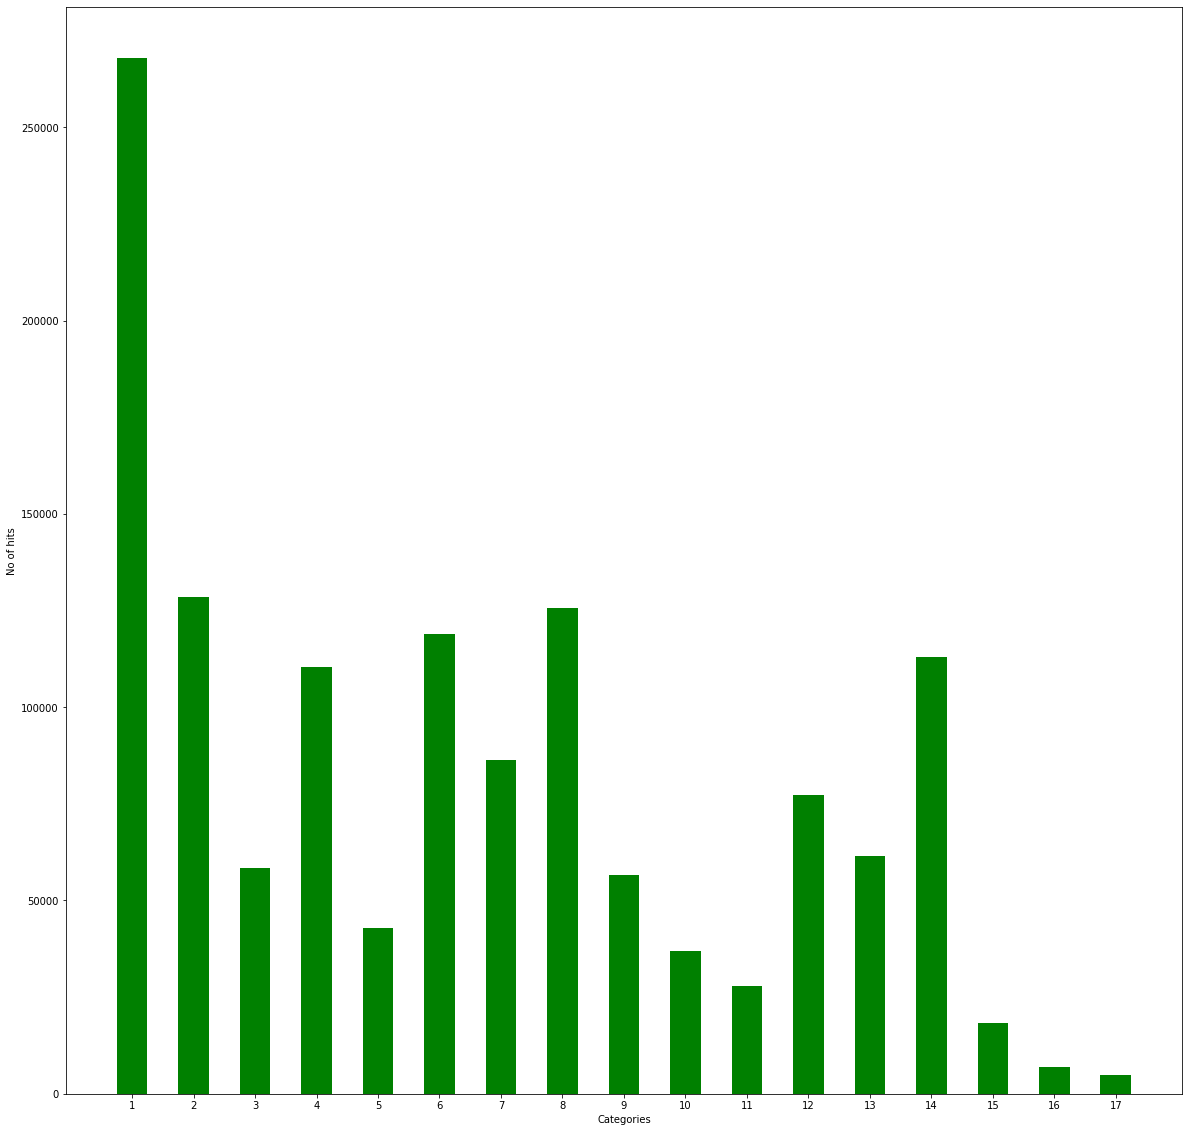

In [ ]:
xpoints = np.array([1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17])
ypoints = np.array([267801, 128589, 58355, 110369, 42885, 118919, 86376, 125523, 56656, 36974, 27989, 77357, 61567, 113040, 18343, 6821, 4900])
plt.figure(figsize=(20,20))
plt.xlabel("Categories")
plt.ylabel("No of hits")
plt.xticks(xpoints)
plt.bar(xpoints, ypoints, width=0.5, color= 'green')
plt.show()

## Application:
# Collaborative Recommender System

* https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html
* https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
* https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.fpm.PrefixSpan

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

 ### ALS 

In [ ]:
# Read datafile

lines = sc.textFile("msnbc990928.seq")
print(type(lines))
# print(lines.collect())

<class 'pyspark.rdd.RDD'>


In [ ]:
als_lines = lines.map(lambda value: value.split(" "))
als_lines = als_lines.map(lambda value: value[:-1])
als_lines.take(10)

[['1', '1'],
 ['2'],
 ['3', '2', '2', '4', '2', '2', '2', '3', '3'],
 ['5'],
 ['1'],
 ['6'],
 ['1', '1'],
 ['6'],
 ['6', '7', '7', '7', '6', '6', '8', '8', '8', '8'],
 ['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4']]

In [ ]:
als_lines2 = als_lines.zipWithIndex().map(lambda value : [(str(value[1]+1)+" "+str(i), 1) for i in value[0]])
als_lines2.take(5)

[[('1 1', 1), ('1 1', 1)],
 [('2 2', 1)],
 [('3 3', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 4', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 2', 1),
  ('3 3', 1),
  ('3 3', 1)],
 [('4 5', 1)],
 [('5 1', 1)]]

In [ ]:
als_lines3 = als_lines2.flatMap(lambda value: value)
als_lines3.take(10)

[('1 1', 1),
 ('1 1', 1),
 ('2 2', 1),
 ('3 3', 1),
 ('3 2', 1),
 ('3 2', 1),
 ('3 4', 1),
 ('3 2', 1),
 ('3 2', 1),
 ('3 2', 1)]

In [ ]:
rdd_reduce_als = als_lines3.reduceByKey(lambda x, y: x+y)
rdd_reduce_als.take(10)

[('1 1', 2),
 ('3 3', 3),
 ('4 5', 1),
 ('5 1', 1),
 ('9 7', 3),
 ('10 6', 1),
 ('10 3', 1),
 ('10 5', 1),
 ('11 1', 6),
 ('11 11', 1)]

In [ ]:
rdd_map3_als = rdd_reduce_als.map(lambda value: (int(value[0].split(" ")[0]), int(value[0].split(" ")[1]), int(value[1]))).sortBy(lambda r: r[0])
rdd_map3_als.take(10)

[(1, 1, 2),
 (2, 2, 1),
 (3, 3, 3),
 (3, 2, 5),
 (3, 4, 1),
 (4, 5, 1),
 (5, 1, 1),
 (6, 6, 1),
 (7, 1, 2),
 (8, 6, 1)]

In [ ]:
rdd_map4_als = rdd_map3_als.map(lambda value: Row(userId=value[0],category=value[1], freq=value[2]))
rdd_map4_als.take(10)

[Row(userId=1, category=1, freq=2),
 Row(userId=2, category=2, freq=1),
 Row(userId=3, category=3, freq=3),
 Row(userId=3, category=2, freq=5),
 Row(userId=3, category=4, freq=1),
 Row(userId=4, category=5, freq=1),
 Row(userId=5, category=1, freq=1),
 Row(userId=6, category=6, freq=1),
 Row(userId=7, category=1, freq=2),
 Row(userId=8, category=6, freq=1)]

In [ ]:
ALS_df = rdd_map4_als.toDF()

In [ ]:
ALS_df.show()

+------+--------+----+
|userId|category|freq|
+------+--------+----+
|     1|       1|   2|
|     2|       2|   1|
|     3|       3|   3|
|     3|       2|   5|
|     3|       4|   1|
|     4|       5|   1|
|     5|       1|   1|
|     6|       6|   1|
|     7|       1|   2|
|     8|       6|   1|
|     9|       7|   3|
|     9|       6|   3|
|     9|       8|   4|
|    10|       6|   1|
|    10|       3|   1|
|    10|       5|   1|
|    10|       9|   1|
|    10|       4|   6|
|    10|      10|   3|
|    11|       1|   6|
+------+--------+----+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [ ]:
(training, test) = ALS_df.randomSplit([0.8, 0.2])


In [ ]:
als = ALS(maxIter = 20, regParam = 0.01, userCol = "userId", itemCol = "category", ratingCol = "freq", coldStartStrategy="drop")
model = als.fit(ALS_df)

In [ ]:
predictions = model.transform(test)
predictions.show()

+------+--------+----+----------+
|userId|category|freq|prediction|
+------+--------+----+----------+
|    53|       1|   2| 1.9466476|
|    65|       1|   1| 0.9859009|
|    78|       1|   6|  5.524321|
|   108|       1|   2| 1.9718018|
|   222|       1|   1| 0.9859009|
|   285|       1|   1|0.97744703|
|   291|       1|   2| 1.9219663|
|   305|       1|   2| 1.9452293|
|   363|       1|   1| 0.9859009|
|   625|       1|   2| 1.9718018|
|   772|       1|   3| 2.9175038|
|   833|       1|   1| 0.9738533|
|   844|       1|   1| 0.9729037|
|   857|       1|   1| 1.1926606|
|   861|       1|   1| 0.9859009|
|   976|       1|   1| 0.9859009|
|  1016|       1|   1| 0.9747075|
|  1047|       1|   2| 1.9462285|
|  1064|       1|   3| 2.9577029|
|  1127|       1|   2| 1.9718018|
+------+--------+----+----------+
only showing top 20 rows



In [ ]:
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "freq", predictionCol = "prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE: ", rmse)

RMSE:  0.35226900107926434


In [ ]:
userRecs = model.recommendForAllUsers(5)
userRecs.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{1, 1.9718018}, ...|
|    12|[{16, 4.3525624},...|
|    13|[{1, 1.9718018}, ...|
|    22|[{5, 0.9956304}, ...|
|    26|[{16, 2.1762812},...|
|    27|[{1, 0.9859009}, ...|
|    28|[{16, 7.5506897},...|
|    31|[{14, 0.9980006},...|
|    34|[{6, 0.99365234},...|
|    44|[{16, 5.9571395},...|
|    47|[{5, 0.9956304}, ...|
|    52|[{16, 8.93571}, {...|
|    53|[{1, 1.9466476}, ...|
|    65|[{1, 0.9859009}, ...|
|    76|[{6, 1.9756972}, ...|
|    78|[{1, 5.524321}, {...|
|    81|[{2, 1.9785767}, ...|
|    85|[{10, 5.9581823},...|
|    91|[{6, 0.99365234},...|
|    93|[{8, 1.9795011}, ...|
+------+--------------------+
only showing top 20 rows



In [ ]:
userRecs.where('userId=3').collect()[0][1]

[Row(category=16, rating=15.637073516845703),
 Row(category=2, rating=4.964696407318115),
 Row(category=10, rating=3.5372703075408936),
 Row(category=3, rating=2.882596492767334),
 Row(category=9, rating=1.787173867225647)]

In [ ]:
testRecs = model.recommendForUserSubset(test, 5)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
testRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    44|[{16, 5.9571395},...|
|    47|[{5, 0.9956304}, ...|
|    53|[{1, 1.9466476}, ...|
|    65|[{1, 0.9859009}, ...|
|    78|[{1, 5.524321}, {...|
|    93|[{8, 1.9795011}, ...|
|   103|[{16, 16.492706},...|
|   108|[{1, 1.9718018}, ...|
|   111|[{16, 6.528843}, ...|
|   128|[{14, 0.9980006},...|
|   137|[{16, 10.997052},...|
|   190|[{1, 9.358923}, {...|
|   192|[{7, 2.9509852}, ...|
|   193|[{16, 11.539395},...|
|   206|[{1, 1.9243739}, ...|
|   222|[{1, 0.9859009}, ...|
|   223|[{1, 2.877625}, {...|
|   230|[{7, 2.9527855}, ...|
|   233|[{7, 14.581817}, ...|
|   285|[{2, 3.9681811}, ...|
+------+--------------------+
only showing top 20 rows



In [ ]:
print(type(testRecs))

<class 'pyspark.sql.dataframe.DataFrame'>


###PrefixSpan

In [ ]:
#Sample 
from pyspark.ml.fpm import PrefixSpan

df = sc.parallelize([Row(sequence=[[1, 2, 3]]),
                     Row(sequence=[[1, 3, 2, 1, 2]]),
                     Row(sequence=[[1, 2, 5]]),
                     Row(sequence=[[6]])]).toDF()

prefixSpan = PrefixSpan(minSupport=0.5, maxPatternLength=5,
                        maxLocalProjDBSize=32000000)

# Find frequent sequential patterns.
prefixSpan.findFrequentSequentialPatterns(df).show()

+-----------+----+
|   sequence|freq|
+-----------+----+
|      [[3]]|   2|
|      [[2]]|   3|
|      [[1]]|   3|
|   [[2, 3]]|   2|
|   [[1, 3]]|   2|
|   [[1, 2]]|   3|
|[[1, 2, 3]]|   2|
+-----------+----+



In [ ]:
# Read datafile

lines = sc.textFile("msnbc990928.seq")
print(type(lines))
# print(lines.collect())

<class 'pyspark.rdd.RDD'>


In [ ]:
seq_lines = lines.map(lambda value: value.split(" "))
seq_lines = seq_lines.map(lambda value: Row(sequence=[value[:-1]]))
seq_lines.take(10)

[Row(sequence=[['1', '1']]),
 Row(sequence=[['2']]),
 Row(sequence=[['3', '2', '2', '4', '2', '2', '2', '3', '3']]),
 Row(sequence=[['5']]),
 Row(sequence=[['1']]),
 Row(sequence=[['6']]),
 Row(sequence=[['1', '1']]),
 Row(sequence=[['6']]),
 Row(sequence=[['6', '7', '7', '7', '6', '6', '8', '8', '8', '8']]),
 Row(sequence=[['6', '9', '4', '4', '4', '10', '3', '10', '5', '10', '4', '4', '4']])]

In [ ]:
seq_df = seq_lines.toDF()

In [ ]:
seq_df.show()

+--------------------+
|            sequence|
+--------------------+
|            [[1, 1]]|
|               [[2]]|
|[[3, 2, 2, 4, 2, ...|
|               [[5]]|
|               [[1]]|
|               [[6]]|
|            [[1, 1]]|
|               [[6]]|
|[[6, 7, 7, 7, 6, ...|
|[[6, 9, 4, 4, 4, ...|
|[[1, 1, 1, 11, 1,...|
|          [[12, 12]]|
|            [[1, 1]]|
|[[8, 8, 8, 8, 8, 8]]|
|               [[6]]|
|               [[2]]|
|           [[9, 12]]|
|               [[3]]|
|               [[9]]|
|               [[3]]|
+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.fpm import PrefixSpan
prefixSpan = PrefixSpan(minSupport=0.001, maxPatternLength=100, maxLocalProjDBSize=32000000)


In [ ]:
seq_patterns = prefixSpan.findFrequentSequentialPatterns(seq_df)

In [ ]:
seq_patterns.show()

+-----------+------+
|   sequence|  freq|
+-----------+------+
|      [[7]]| 80514|
|     [[16]]|  2082|
|     [[10]]| 50606|
|     [[14]]|119138|
|      [[1]]|313181|
|      [[9]]| 90192|
|      [[4]]|121719|
|      [[2]]|175286|
|      [[3]]|121948|
|      [[8]]| 95615|
|     [[15]]| 29200|
|     [[11]]| 57597|
|     [[17]]| 11006|
|     [[12]]|112183|
|      [[5]]| 24987|
|     [[13]]| 76948|
|      [[6]]|217101|
|  [[7, 17]]|  1812|
|   [[7, 5]]|  3848|
|[[7, 5, 5]]|  2290|
+-----------+------+
only showing top 20 rows



In [ ]:
# seq_patterns.count()

### FPGrowth


In [ ]:
#Sample 
from pyspark.ml.fpm import FPGrowth

df = spark.createDataFrame([
    (0, [1, 2, 5]),
    (1, [1, 2, 3, 5]),
    (2, [1, 2])
], ["id", "items"])

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.5, minConfidence=0.6)
model = fpGrowth.fit(df)

# Display frequent itemsets.
model.freqItemsets.show()

# Display generated association rules.
model.associationRules.show()

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(df).show()

In [ ]:
# Read datafile

lines = sc.textFile("msnbc990928.seq")
print(type(lines))
# print(lines.collect())

<class 'pyspark.rdd.RDD'>


In [ ]:
seq_lines = lines.map(lambda value: value.split(" "))
seq_lines = seq_lines.zipWithIndex().map(lambda value: Row(id=value[1],categories=list(set(value[0][:-1]))))
seq_lines.take(10)

[Row(id=0, categories=['1']),
 Row(id=1, categories=['2']),
 Row(id=2, categories=['4', '3', '2']),
 Row(id=3, categories=['5']),
 Row(id=4, categories=['1']),
 Row(id=5, categories=['6']),
 Row(id=6, categories=['1']),
 Row(id=7, categories=['6']),
 Row(id=8, categories=['7', '8', '6']),
 Row(id=9, categories=['10', '5', '3', '4', '9', '6'])]

In [ ]:
FPG_df = seq_lines.toDF()

In [ ]:
FPG_df.show()

+---+-------------------+
| id|         categories|
+---+-------------------+
|  0|                [1]|
|  1|                [2]|
|  2|          [4, 3, 2]|
|  3|                [5]|
|  4|                [1]|
|  5|                [6]|
|  6|                [1]|
|  7|                [6]|
|  8|          [7, 8, 6]|
|  9|[10, 5, 3, 4, 9, 6]|
| 10|            [1, 11]|
| 11|               [12]|
| 12|                [1]|
| 13|                [8]|
| 14|                [6]|
| 15|                [2]|
| 16|            [12, 9]|
| 17|                [3]|
| 18|                [9]|
| 19|                [3]|
+---+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="categories", minSupport=0.01, minConfidence=0.5)
model = fpGrowth.fit(FPG_df)

# Display frequent itemsets.
model.freqItemsets.show()

# Display generated association rules.
model.associationRules.show()

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(FPG_df).show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---------+------+
|    items|  freq|
+---------+------+
|      [9]| 90192|
|   [9, 2]| 10255|
|   [9, 4]| 18115|
|   [9, 6]| 15111|
|   [9, 3]| 10383|
|  [9, 12]| 10173|
|   [9, 1]| 11311|
|      [2]|175286|
|   [2, 6]| 25425|
|[2, 6, 1]| 15106|
|   [2, 1]| 74704|
|      [5]| 24987|
|   [5, 1]| 12345|
|      [4]|121719|
|   [4, 2]| 27533|
|[4, 2, 1]| 16566|
|   [4, 6]| 21445|
|   [4, 3]| 13962|
|   [4, 1]| 39183|
|     [13]| 76948|
+---------+------+
only showing top 20 rows

+----------+----------+------------------+------------------+--------------------+
|antecedent|consequent|        confidence|              lift|             support|
+----------+----------+------------------+------------------+--------------------+
|      [11]|       [1]|0.5681198673542025|1.7955599824536035| 0.03305860269261622|
|   [12, 2]|       [1]|0.6619195838485482|2.0920168166197897|0.015683691345277615|
|    [7, 2]|       [1]|0.6501154734411085| 2.054709569515811|0.013082202990852864|
|    [7, 2]|       [